In [1]:
# !pip install tqdm
# !pip install ipywidgets

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow import keras
import json

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Config
n_epochs = 20   # Количество эпох обучения
n_layers = 1    # Число случайных квантовых блоков
n_wires = 3     # Число выходных каналов после квантовых блоков
n_train = 20    # Размер тренировочного датасета
n_test = 10     # Размер тестового датасета

# Инициализация генераторов случайных чисел
np.random.seed(0)           
tf.random.set_seed(255)  

In [3]:
# load mnist
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Ограничение размера датасета
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Нормализация изображений из диапазона (0, 255) в (0, 1)
train_images = train_images / 255
test_images = test_images / 255

# Добавление дополнительной размерности к данным для сверточных каналов
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## Braket Simulator

In [5]:
dev = qml.device("default.qubit", wires=n_wires)

# Генерация значений параметров для квантовых слоев
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_wires))

@qml.qnode(dev)
def circuit(phi):
    # Кодирование 3 классических входных данных
    for j in range(n_wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Случайная квантовая цепь
    RandomLayers(rand_params, wires=list(range(n_wires)))

    # Измерения, которые дают 3 классических выходных значений для следующих слоев
    return [qml.expval(qml.PauliZ(j)) for j in range(n_wires)]

In [6]:
def quanv(image):
    """Функция квантовой свертки над входным изображением."""
    out = np.zeros((14, 14, n_wires))

    # Циклы по координатам верхнего левого пикселя блоков 2х2
    for j in tqdm(range(0, 28, 2)):
        for k in range(0, 28, 2):
            # Обработка блока 2x2 из изображения квантовой цепью
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Запись результатов наблюдения в выходной пиксель (j/2, k/2)
            for c in range(n_wires):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [7]:
q_train_images = []
for idx, img in enumerate(tqdm(train_images)):
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)
print("Train preprocessing complete")

q_test_images = []
for idx, img in enumerate(tqdm(test_images)):
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)
print("Test preprocessing complete")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train preprocessing complete


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Test preprocessing complete


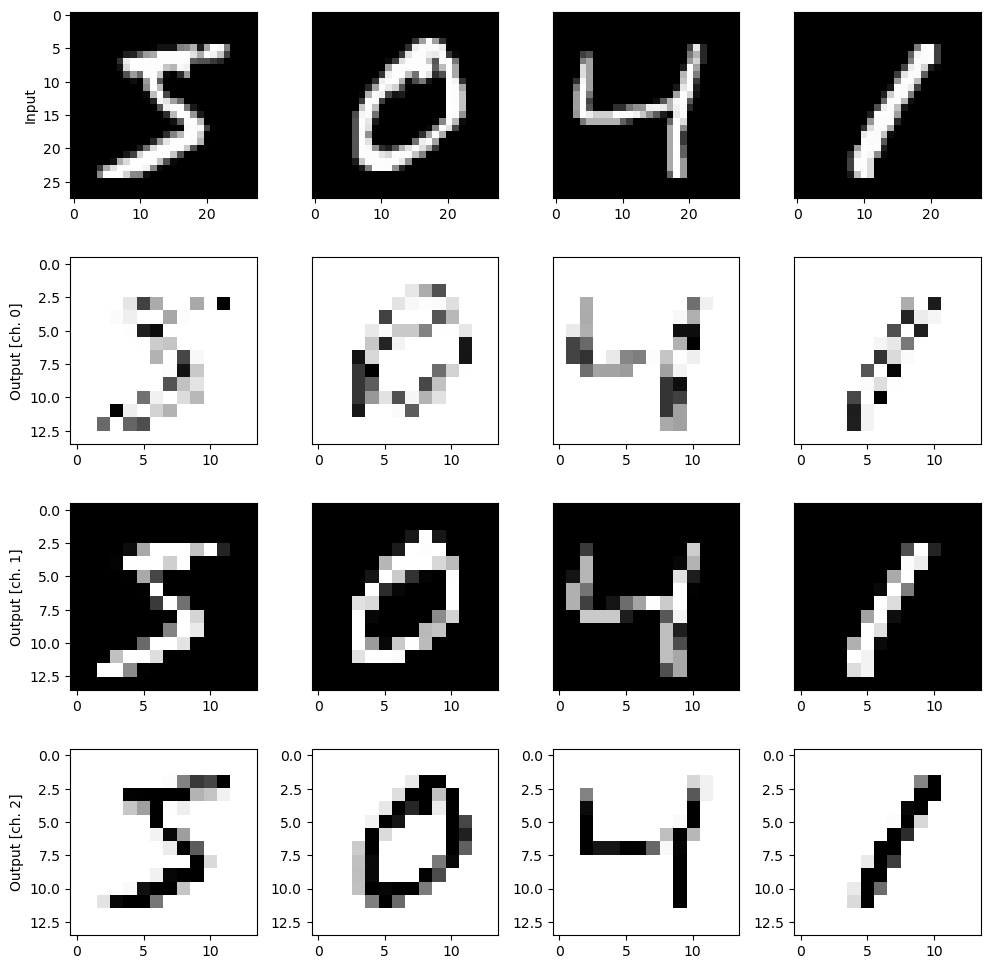

In [8]:
n_samples = 4
n_channels = n_wires
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [9]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [10]:
# train quantum NN
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

In [11]:
# train normal NN
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

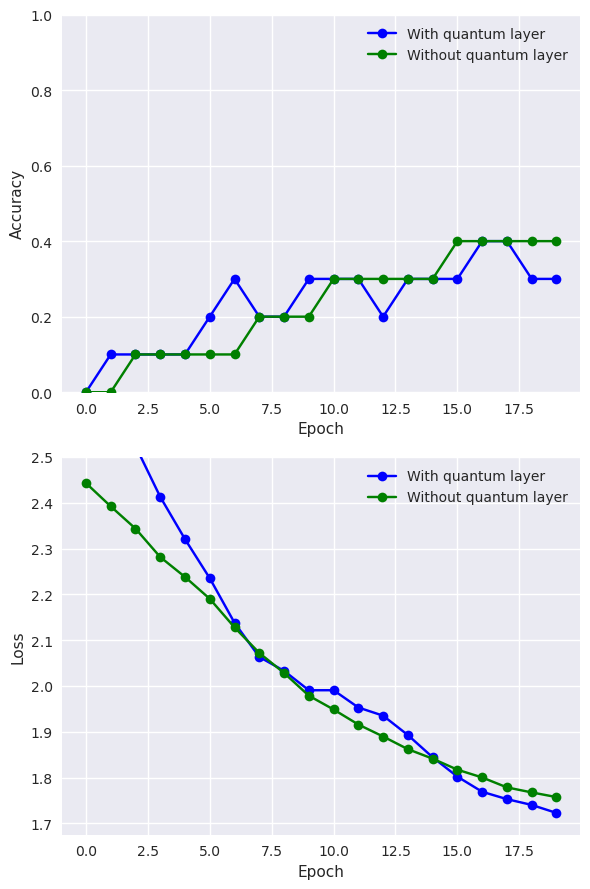

In [12]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## Baket Simulator

In [4]:
# QPU
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
with open("config.json", "r") as f:
    config = json.load(f)
s3_folder = (config["my_bucket"], config["my_prefix"])
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=n_wires, s3_destination_folder=s3_folder)

# Генерация значений параметров для квантовых слоев
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_wires))

@qml.qnode(dev)
def circuit(phi):
    # Кодирование 3 классических входных данных
    for j in range(n_wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Случайная квантовая цепь
    RandomLayers(rand_params, wires=list(range(n_wires)))

    # Измерения, которые дают 3 классических выходных значений для следующих слоев
    return [qml.expval(qml.PauliZ(j)) for j in range(n_wires)]

In [5]:
def quanv(image):
    """Функция квантовой свертки над входным изображением."""
    out = np.zeros((14, 14, n_wires))

    # Циклы по координатам верхнего левого пикселя блоков 2х2
    for j in tqdm(range(0, 28, 2)):
        for k in range(0, 28, 2):
            # Обработка блока 2x2 из изображения квантовой цепью
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Запись результатов наблюдения в выходной пиксель (j/2, k/2)
            for c in range(n_wires):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [6]:
qpu_images = []
for idx, img in enumerate(tqdm(train_images[:4])):
    qpu_images.append(quanv(img))
qpu_images = np.asarray(qpu_images)
print("QPU preprocessing complete")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

QPU preprocessing complete


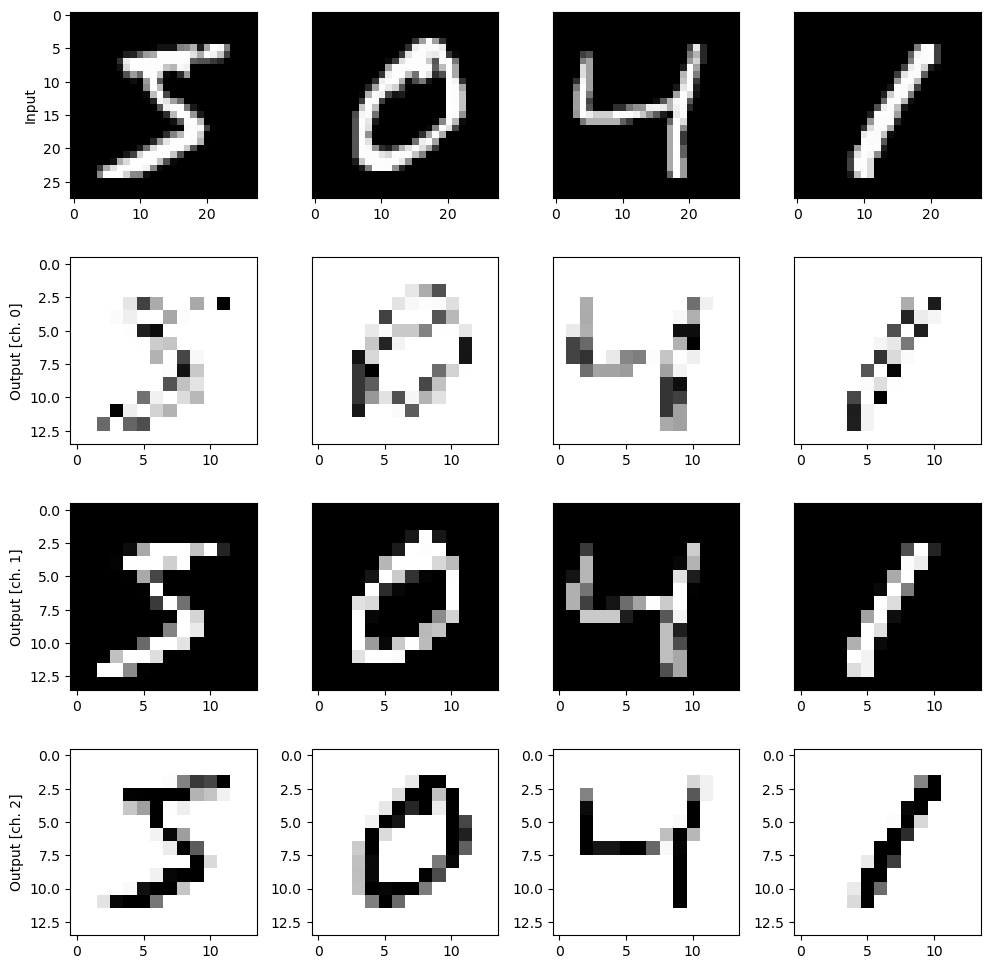

In [10]:
n_samples = 4
n_channels = n_wires
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(qpu_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()